# Stage 1. Crop yield prediction. Linear regression. Maize

In [1]:
# Загрузка всех необходимых библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats
from datetime import datetime
from pyproj import Proj, transform
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, PassiveAggressiveRegressor, SGDRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import RANSACRegressor
import pickle

from datetime import date
import warnings
warnings.filterwarnings("ignore")

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

## Functions

In [2]:
def cum_sum(array, years):
    rcParams['figure.figsize'] = 15, 8
    # Рассчет накопленных сумм
    cumsum_array = np.cumsum(array)
    
    # Рассчитываем среднюю разницу между соседними элементами массива
    diffs = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            pass
        else:
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            diff = current - last
            diffs.append(diff)
    diffs = np.array(diffs)
    
    # Медианное значение разницы между соседними элементами
    median_diff = np.median(diffs)
    
    # Поиск наиболее заметного перелома:
    fractures = []
    for i in range(0, len(cumsum_array)):
        if i == 0:
            fractures.append(0)
        elif i == 1:
            fractures.append(0)
        else:
            # Используются данные текущего наблюдения + за два предыдущих наблюдения
            pre_last = cumsum_array[i-2]
            last = cumsum_array[i-1]
            current = cumsum_array[i]
            # Действующая разница 
            curr_diff = current - last
            # Разница, которая была на предыдущем шаге
            last_diff = last - pre_last
            # Среднее значение
            main_diff = (curr_diff + last_diff)/2
            
            # Насколько действующая разница больше или меньше среднего значения разности
            value = abs(main_diff - median_diff)
            fractures.append(value)
    fractures = np.array(fractures)
    
    # Условимся считать, что первые 15 и последние 15 элементов в ряду 
    # нам не слудет рассматривать при поиске излома
    new_fractures = fractures[15:-15]
        
    # Допустимый уровень расхожения - 40 процентов
    threshold = ((max(array) - min(array))/100)*40
    # Если хотя бы одно значение из массива больше порогового, то мы имеем дело с изломом
    if any(threshold < fracture for fracture in new_fractures):
        # Индекс "переломного момента"
        id_fracture = np.argwhere(fractures == max(new_fractures))[0][0]
        year_fracture = int(years[id_fracture])
        
        # Линейная регрессия для первой части ряда
        LR1 = LinearRegression()
        years_1 = np.array(years[:id_fracture]).reshape((-1,1))
        cumsum_1 =  np.array(cumsum_array[:id_fracture]).reshape((-1,1))
        LR1.fit(years_1, cumsum_1)
        
        # Линейная регрессия для второй части ряда
        LR2 = LinearRegression()
        years_2 = np.array(years[id_fracture:]).reshape((-1,1))
        cumsum_2 =  np.array(cumsum_array[id_fracture:]).reshape((-1,1))
        LR2.fit(years_2, cumsum_2)
        
        
        # Зададим две точки, по которым будем рисовать прямую
        l1 = np.array([[min(years)], [max(years)]])
        l2 = np.array([[1969], [max(years)]])

        plt.plot(years, cumsum_array, '-ok', c = 'blue', alpha = 0.7, label = 'Cumulative sum')
        plt.plot(l1, LR1.predict(l1), c = 'red', alpha = 0.5, label = 'The first part with extrapolation', linewidth = 3)
        plt.plot(l2, LR2.predict(l2), c = 'orange', alpha = 0.5, label = 'The second part with the extrapolation', linewidth = 3)
        plt.scatter(years[id_fracture], cumsum_array[id_fracture], c = 'yellow', s = 400, alpha = 0.8, label = 'The expected point of fracture')
        plt.xlabel('Year', fontsize = 15)
        plt.ylabel('Cumulative sum', fontsize = 15)
        plt.legend(fontsize = 12)
        plt.grid()
        plt.show()

        print('Estimated fracture year -', year_fracture)
        print('Index of the expected fracture -', id_fracture)
    else:
        print('No fractures were found')
        
# Расчет метрики - cредняя абсолютная процентная ошибка
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    # У представленной ниже формулы есть недостаток, - если в массиве y_true есть хотя бы одно значение 0.0,
    # то по формуле np.mean(np.abs((y_true - y_pred) / y_true)) * 100 мы получаем inf, поэтому
    zero_indexes = np.argwhere(y_true == 0.0)
    for index in zero_indexes:
        y_true[index] = 0.01
    value = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return(value)

# Зададим функцию, которая будет выводить на экран значения метрик
def print_metrics(y_test, prediction, model, r2 = False):
    print('Mean absolute error in the test sample -', mean_absolute_error(y_test, prediction))
    print('Median absolute error in the test sample -', median_absolute_error(y_test, prediction))
    print('Root mean square error in the test sample -', mean_squared_error(y_test, prediction)**0.5)
    print('Mean absolute percentage error in the test sample -',mean_absolute_percentage_error(y_test, prediction))
    if r2 == True:
        print('Coefficient of determination in the training sample -', r2_score(y_train, model.predict(X_train)))

# Зададим функцию для отрисовки графиков
def residuals_plots(y_test, prediction, color = 'blue'):
    prediction = np.ravel(prediction)
    y_test = np.ravel(y_test)
    # Рассчитываем ошибки
    errors = prediction - y_test
    errors = np.ravel(errors)
    
    plot_data = pd.DataFrame({'Errors': errors,
                              'Prediction': prediction})
    
    with sns.axes_style("ticks"):
        g = (sns.jointplot('Prediction', 'Errors',  height = 7, alpha = 0.6,
                           data=plot_data, color= color).plot_joint(sns.kdeplot, zorder=0, n_levels=6))
        g.ax_joint.plot([min(prediction)-0.1, max(prediction)+0.1],[0, 0], linewidth = 1, linestyle='--', color= color)
        g.ax_marg_y.axhline(y = 0, linewidth = 1, linestyle='--', color= color)
        plt.xlabel('Predicted value', fontsize = 15)
        plt.ylabel('Errors, tones/ha', fontsize = 15)
        plt.show()
        
        g = (sns.jointplot('Prediction', 'Errors', kind="kde", data = plot_data, space=0, height = 7,
                      color = color, alpha = 0.2))
        g.set_axis_labels('Predicted value', 'Errors, tones/ha', fontsize = 15)
        g.ax_joint.plot([min(prediction)-0.1, max(prediction)+0.1],[0, 0], linewidth = 1, linestyle='--', color= color)
        g.ax_marg_y.axhline(y = 0, linewidth = 1, linestyle='--', color= color)
        plt.show()

## Germany


In [3]:
data_germany = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/Germany.csv', sep = ',')
data_germany.dropna(axis=1, inplace=True)
data_germany.drop('Entity', inplace=True, axis=1)
data_germany.drop('Greece_pressure', inplace=True, axis=1)
data_germany.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      410.88678         79.0     1012.66360       1009.20120   
1      322.17752         75.0     1011.81710       1009.78467   
2      245.21330         57.0     1011.87775       1016.32874   
3      251.77277         58.0     1014.76843       1015.11957   
4      435.08688         86.0     1010.86523       1011.64570   
5      402.59814         79.0     1010.21100       1014.03540   
6      352.10046         75.0     1012.47205       1009.69420   
7      345.32140         73.0     1011.17490       1009.11145   
8      368.43762         72.0     1009.94324       1015.93990   
9      416.41196         85.0     1008.81020       1012.04740   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0        1013.95790         1019.94550        29.394403       -14.834928   
1        1016.03094         1018.48090        28.767439       -12.438088   
2        1012.46265         1015.33850        27.909672       -21.614204   
3        1015.07240         1017.66310        31.479586       -14.799795   
4        1014.87500         1018.06440        27.520174       -14.626988   
5        1009.56040         1017.36520        30.226630       -17.142650   
6        1014.27050         1019.34357        29.694954       -13.792070   
7        1014.11380         1017.58850        29.823790       -18.766098   
8        1011.61285         1015.11566        29.497080       -14.574210   
9        1012.38770         1017.49230        29.856928       -15.999550   

   Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0        949.72990  1961                      2.8607   
1        692.69360  1962                      3.3898   
2        900.89180  1963                      3.3934   
3       1031.59410  1964                      3.4845   
4        747.54750  1965                      3.2321   
5       1020.20700  1966                      3.2325   
6        810.26240  1967                      4.0216   
7        953.11630  1968                      4.2162   
8        858.79724  1969                      3.8877   
9        860.01886  1970                      3.7264   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      2.8979                        18.0590   
1                      3.2319                        22.5080   
2                      3.4526                        23.1439   
3                      3.3691                        20.9811   
4                      3.5354                        20.5188   
5                      4.0115                        22.2060   
6                      4.6993                        25.3808   
7                      4.8943                        23.9100   
8                      4.8750                        20.7995   
9                      4.9743                        23.1893   

   Peas (tonnes per hectare)  Barley (tonnes per hectare)  \
0                     1.3891                       2.3640   
1                     1.5287                       3.2451   
2                     1.1979                       3.0346   
3                     1.3946                       3.3476   
4                     1.7530                       2.9678   
5                     1.5339                       2.9816   
6                     1.8902                       3.5797   
7                     1.6500                       3.6844   
8                     1.6261                       3.5487   
9                     1.7190                       3.1587   

   Total population (Gapminder)  Land used for cereal (hectares)  \
0                    73928000.0                        7138919.0   
1                    74489000.0                        7145685.0   
2                    75081000.0                        7168885.0   
3                    75677000.0                        7285822.0   
4                    76258000.0                        7229500.0   
5                    76820000.0                 

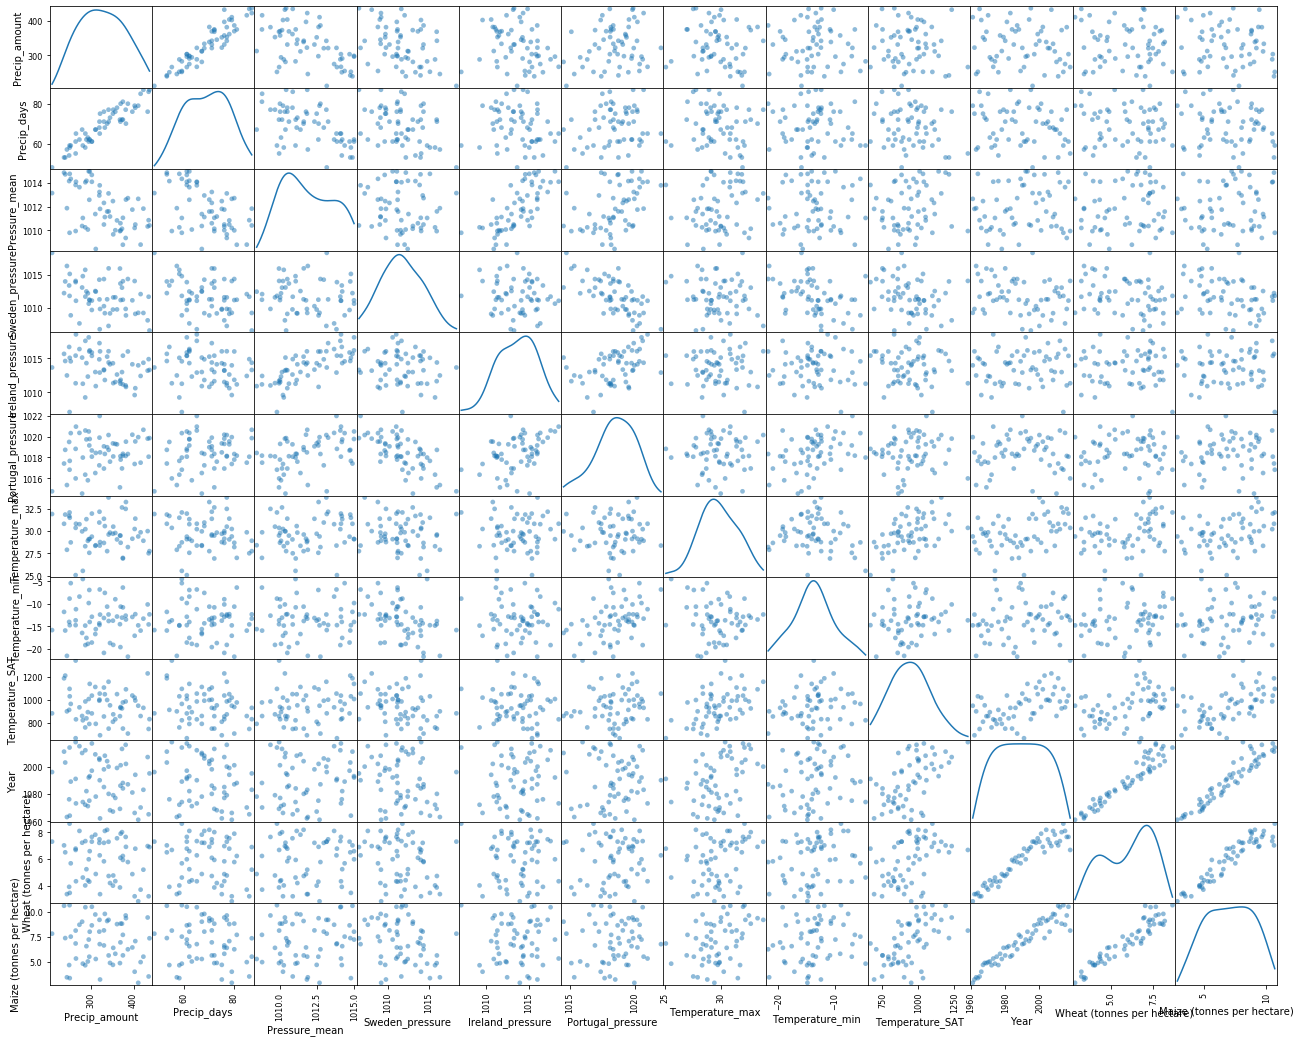

In [4]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_germany.loc[:, "Precip_amount":"Maize (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

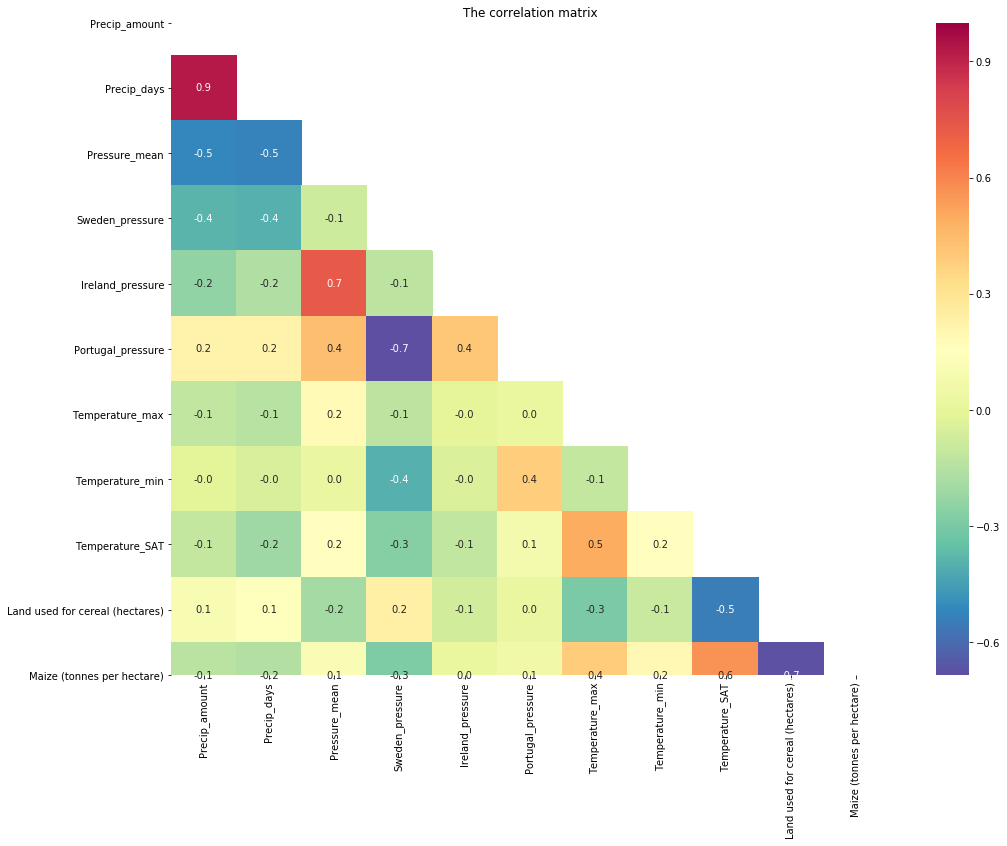

In [5]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_germany[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Maize (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.

In [6]:
cum_sum(data_germany['Maize (tonnes per hectare)'], data_germany['Year'])

No fractures were found


Thus, we assume that the sample is homogeneous.

### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min
* Year

In [7]:
data_germany['year'] = data_germany['Year']
data_germany.set_index('year', inplace=True)
data_train = data_germany.loc[1961:2003]
data_test = data_germany.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
                          
y_train = data_train['Maize (tonnes per hectare)']
y_test = data_test['Maize (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Germany = LR.predict(X_test)

### Results

Mean absolute error in the test sample - 0.7728835079585097
Median absolute error in the test sample - 0.5754916229795075
Root mean square error in the test sample - 1.1335052191047825
Mean absolute percentage error in the test sample - 9.009125006672122
Coefficient of determination in the training sample - 0.920647204024699


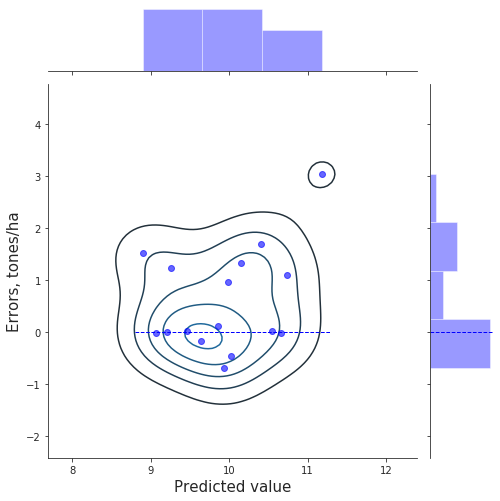

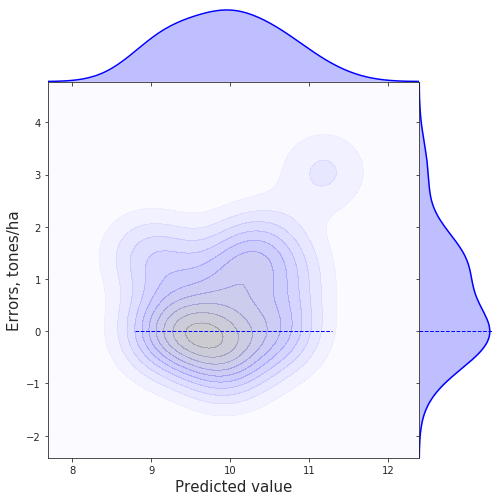

In [8]:
print_metrics(y_test, predicted_Germany, LR, r2 = True)
residuals_plots(y_test, predicted_Germany, color = 'blue')

## France

In [9]:
data_france = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/France.csv', sep = ',')
data_france.dropna(axis=1, inplace=True)
data_france.drop('Entity', inplace=True, axis=1)
data_france.drop('Greece_pressure', inplace=True, axis=1)
data_france.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      325.93912         57.0     1007.24774       1009.20120   
1      342.90512         60.0     1006.49133       1009.78467   
2      382.09140         67.0     1003.21857       1016.32874   
3      327.59335         56.0     1006.48865       1015.11957   
4      351.55725         67.0     1013.66675       1011.64570   
5      411.58084         72.0     1010.90375       1014.03540   
6      296.96448         57.0     1006.91370       1009.69420   
7      385.63324         68.0     1001.73690       1009.11145   
8      414.32663         72.0     1006.93054       1015.93990   
9      444.39444         82.0     1010.25480       1012.04740   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0        1013.95790         1019.94550        30.120226        -4.689397   
1        1016.03094         1018.48090        28.775826        -7.723627   
2        1012.46265         1015.33850        28.332193       -14.741704   
3        1015.07240         1017.66310        30.104681        -7.877462   
4        1014.87500         1018.06440        29.051224        -7.996733   
5        1009.56040         1017.36520        28.349771       -13.237412   
6        1014.27050         1019.34357        28.774730       -10.169624   
7        1014.11380         1017.58850        28.437063        -9.248039   
8        1011.61285         1015.11566        28.175104        -9.653745   
9        1012.38770         1017.49230        28.290894        -8.483588   

   Temperature_SAT  Year  ...  Rice (tonnes per hectare)  \
0        1328.3259  1961  ...                     4.0512   
1         936.9235  1962  ...                     4.1875   
2        1050.1377  1963  ...                     3.9753   
3        1228.5634  1964  ...                     4.0610   
4        1091.6735  1965  ...                     3.2935   
5        1288.5459  1966  ...                     3.6562   
6        1039.5110  1967  ...                     4.3027   
7        1045.5710  1968  ...                     3.4635   
8        1090.6304  1969  ...                     4.1631   
9        1076.6588  1970  ...                     4.2177   

   Maize (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                      2.5291                        16.0992   
1                      2.1489                        15.5289   
2                      4.0593                        18.9265   
3                      2.3546                        16.7369   
4                      3.9800                        19.5147   
5                      4.5037                        19.7618   
6                      4.0880                        20.1900   
7                      5.2643                        21.3276   
8                      4.8346                        21.5372   
9                      5.0994                        22.2184   

   Beans (tonnes per hectare)  Peas (tonnes per hectare)  \
0                      0.9076                     1.9000   
1                      0.8428                     2.4239   
2                      1.0840                     2.2292   
3                      0.9134                     2.2645   
4                      1.0500                     2.1996   
5                      1.3729                     2.2675   
6                      1.0112                     2.5457   
7                      1.3405                     2.3970   
8                      1.1518                     2.7660   
9                      1.3197                     3.4089   

   Barley (tonnes per hectare)  Total population (Gapminder)  \
0                       2.3960                    46267000.0   
1                       2.7581                    46907000.0   
2                       2.9088                    47561000.0   
3                       2.8774                    48184000.0   
4                       3.0363                    48747000.0   
5                       2.8093         

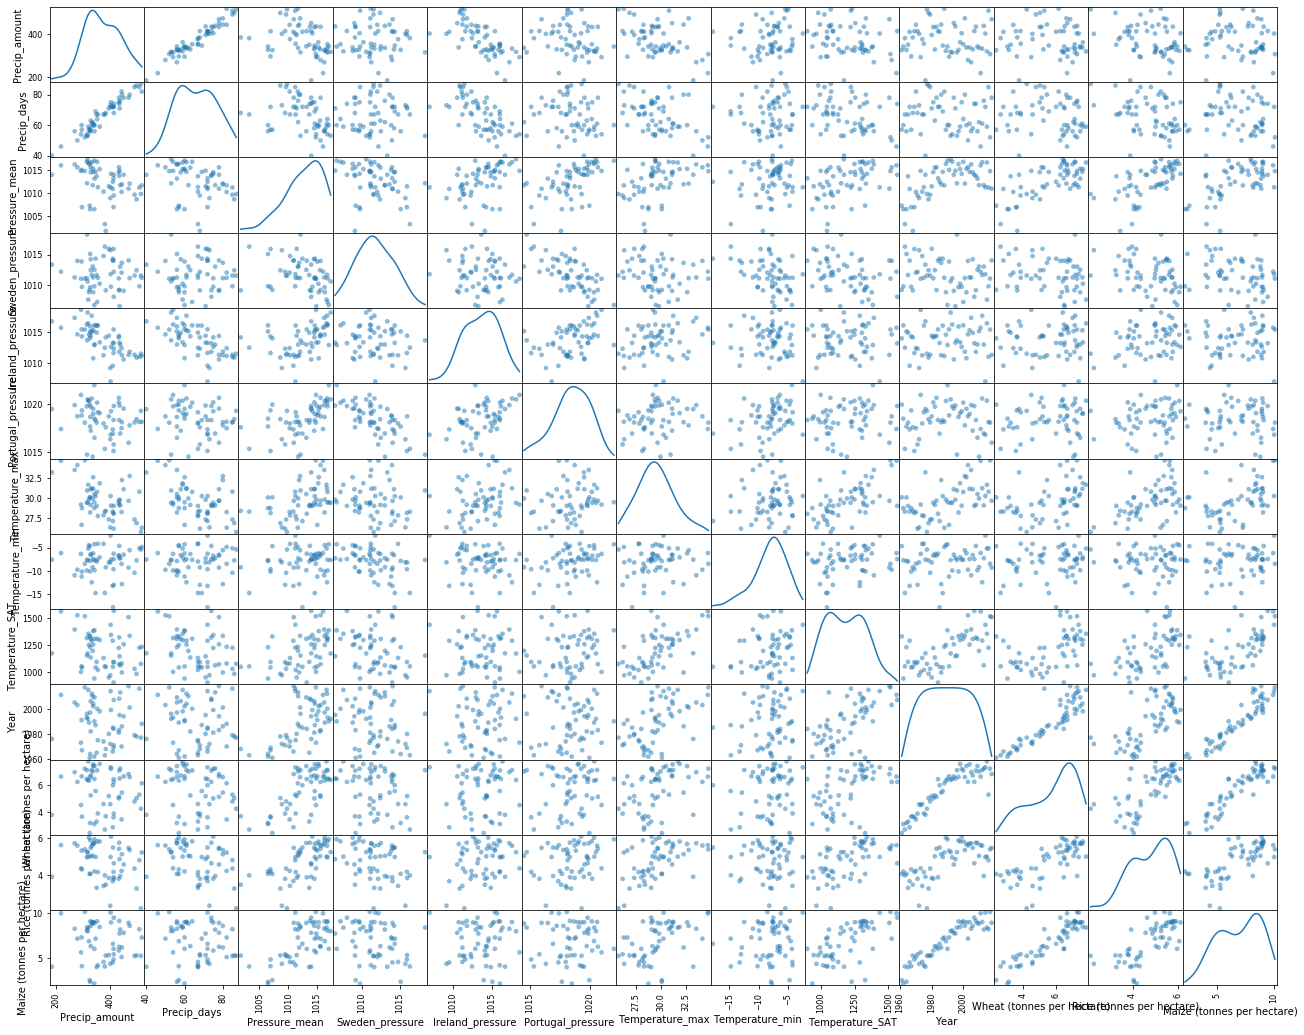

In [10]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_france.loc[:, "Precip_amount":"Maize (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

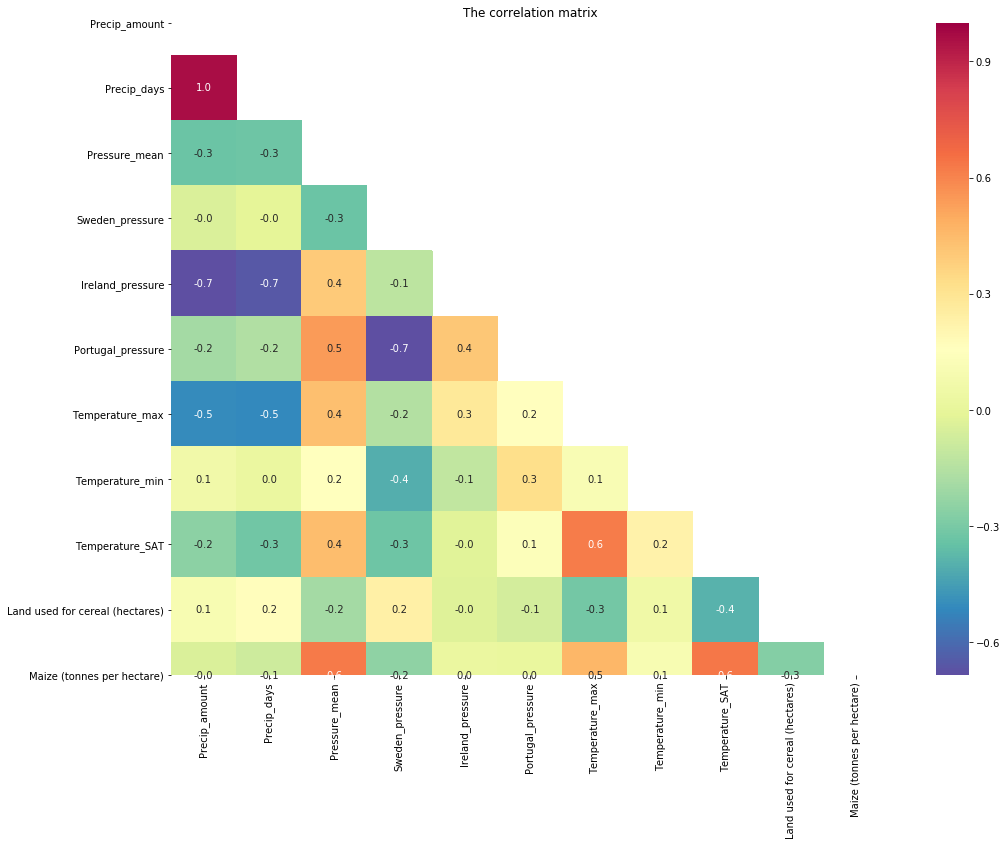

In [11]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_france[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Maize (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.


In [12]:
cum_sum(data_france['Maize (tonnes per hectare)'], data_france['Year'])

No fractures were found


### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min
* Year

In [13]:
data_france['year'] = data_france['Year']
data_france.set_index('year', inplace=True)
data_train = data_france.loc[1961:2003]
data_test = data_france.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
                          
y_train = data_train['Maize (tonnes per hectare)']
y_test = data_test['Maize (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_France = LR.predict(X_test)

Mean absolute error in the test sample - 1.0620799844574802
Median absolute error in the test sample - 0.9031441601888197
Root mean square error in the test sample - 1.3312027892510485
Mean absolute percentage error in the test sample - 12.54601123723372
Coefficient of determination in the training sample - 0.8945437457895805


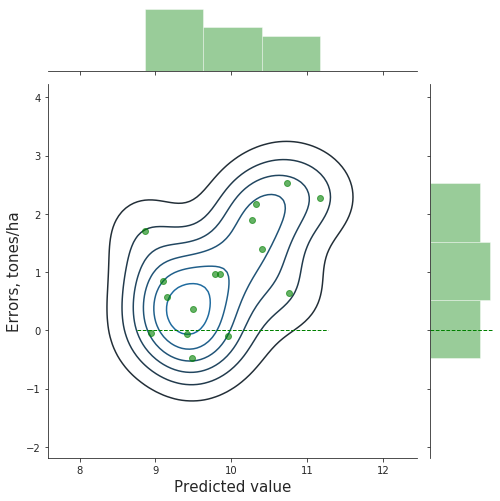

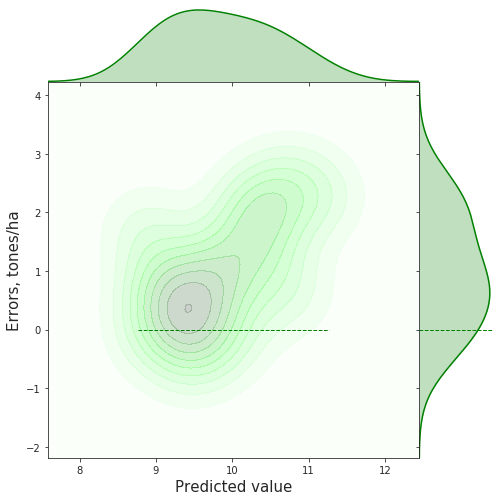

In [14]:
print_metrics(y_test, predicted_France, LR, r2 = True)
residuals_plots(y_test, predicted_France, color = 'green')

## Italy


In [15]:
data_italy = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/Italy.csv', sep = ',')
data_italy.dropna(axis=1, inplace=True)
data_italy.drop('Entity', inplace=True, axis=1)
data_italy.drop('Greece_pressure', inplace=True, axis=1)
data_italy.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      313.68360         39.0      824.96790       1009.20120   
1      333.81363         43.0      823.08580       1009.78467   
2      468.34744         59.0      821.62940       1016.32874   
3      339.38754         42.0      824.82960       1015.11957   
4      359.03128         47.0      818.11530       1011.64570   
5      334.34058         44.0      816.94440       1014.03540   
6      303.73935         38.0      817.50653       1009.69420   
7      366.20370         47.0      816.08450       1009.11145   
8      415.82970         52.0      814.29060       1015.93990   
9      357.73035         48.0      815.21870       1012.04740   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0        1013.95790         1019.94550        30.921100        -4.208682   
1        1016.03094         1018.48090        30.644110        -6.363540   
2        1012.46265         1015.33850        30.261255        -9.621695   
3        1015.07240         1017.66310        29.928915        -5.923607   
4        1014.87500         1018.06440        31.940600        -6.027132   
5        1009.56040         1017.36520        30.072954        -7.571830   
6        1014.27050         1019.34357        29.254396        -7.070186   
7        1014.11380         1017.58850        29.072212        -8.705029   
8        1011.61285         1015.11566        28.277111        -6.715168   
9        1012.38770         1017.49230        29.651218        -4.565250   

   Temperature_SAT  Year  ...  Maize (tonnes per hectare)  \
0        1652.7484  1961  ...                      3.2882   
1        1422.1277  1962  ...                      2.9129   
2        1432.2717  1963  ...                      3.2949   
3        1585.9147  1964  ...                      3.6907   
4        1387.4731  1965  ...                      3.2278   
5        1606.9575  1966  ...                      3.5532   
6        1457.5531  1967  ...                      3.7961   
7        1578.5613  1968  ...                      4.1261   
8        1418.8383  1969  ...                      4.5235   
9        1413.5669  1970  ...                      4.6344   

   Soybeans (tonnes per hectare)  Potatoes (tonnes per hectare)  \
0                         1.9167                        10.3832   
1                         1.7824                         9.4531   
2                         1.8214                        11.3594   
3                         1.8333                        10.7440   
4                         1.8077                        10.1908   
5                         1.9455                        11.1140   
6                         2.0455                        11.8246   
7                         1.9588                        12.4119   
8                         2.0337                        12.9811   
9                         2.0482                        12.8052   

   Beans (tonnes per hectare)  Peas (tonnes per hectare)  \
0                      0.5124                     0.6701   
1                      0.4704                     0.8211   
2                      0.6283                     0.8249   
3                      0.6803                     0.8661   
4                      0.5788                     0.8912   
5                      0.6216                     0.9303   
6                      0.6827                     0.9778   
7                      0.7202                     0.9305   
8                      0.7832                     1.0015   
9                      0.8295                     1.3535   

   Barley (tonnes per hectare)  Total population (Gapminder)  \
0                       1.2690                    50052000.0   
1                       1.3616                    50442000.0   
2                       1.3736                    50856000.0   
3                       1.2798                    51273000.0   
4                       1.5290                    51677000.

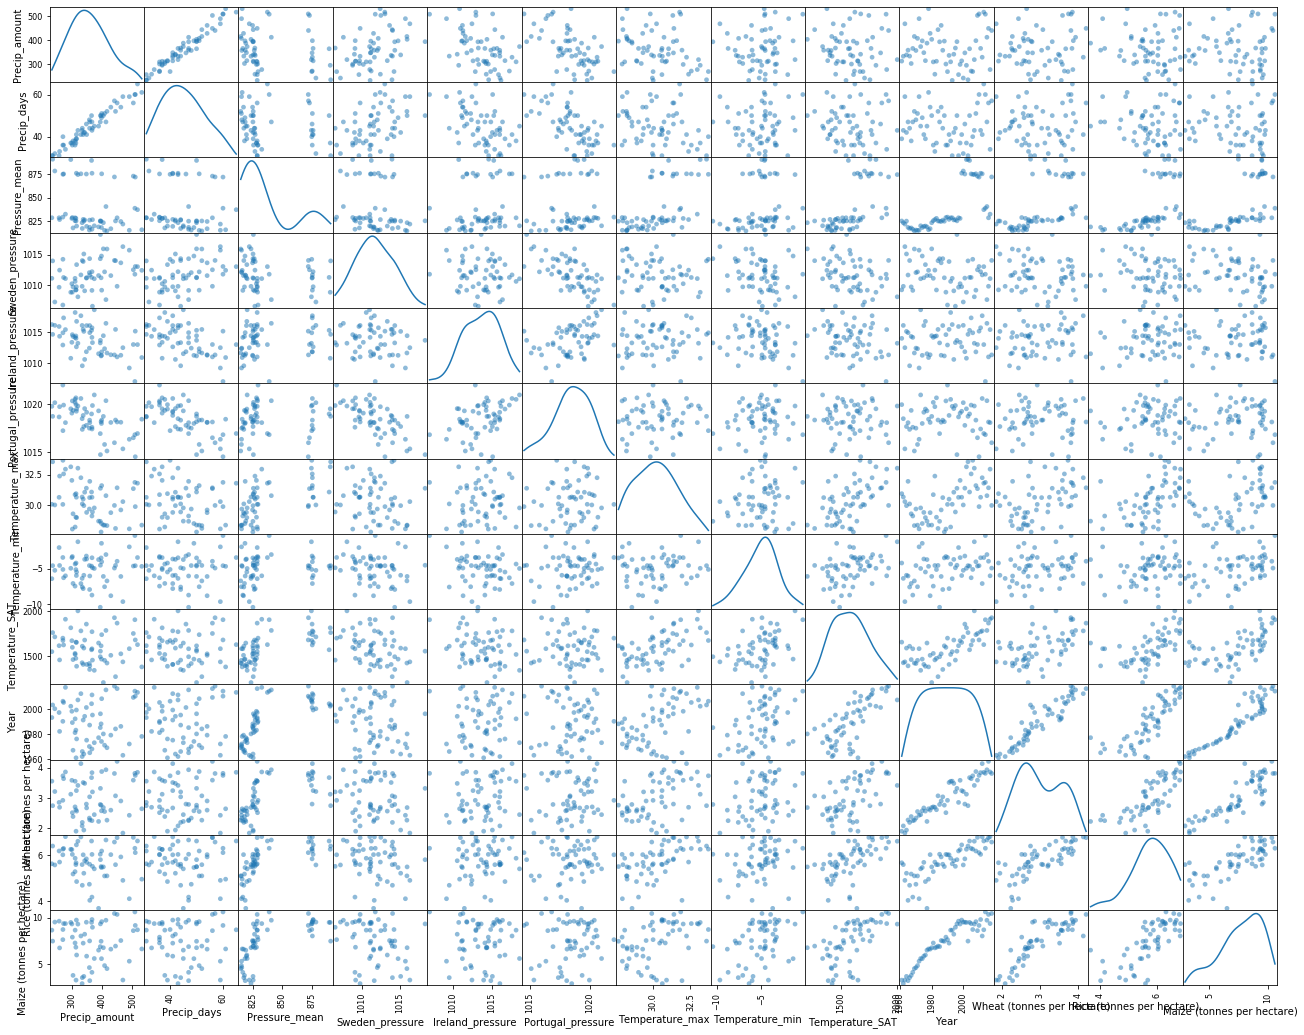

In [16]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_italy.loc[:, "Precip_amount":"Maize (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

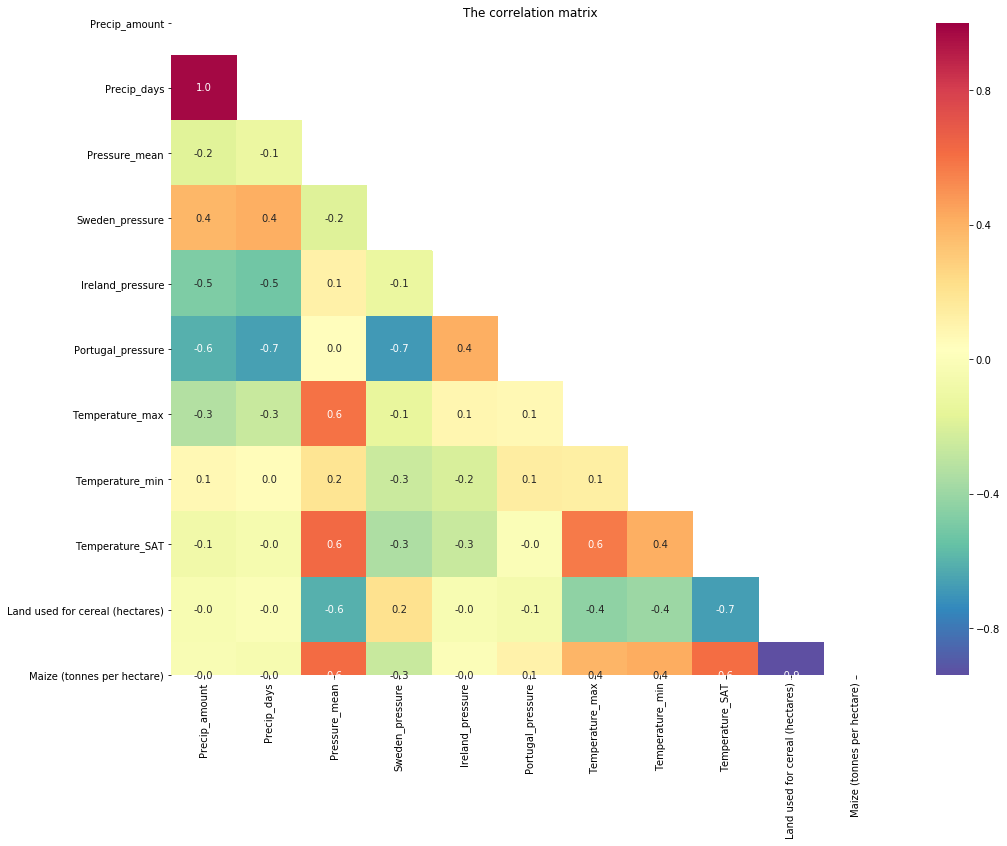

In [17]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_italy[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Maize (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.

In [18]:
cum_sum(data_italy['Maize (tonnes per hectare)'], data_italy['Year'])

No fractures were found


### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min

In [19]:
data_italy['year'] = data_italy['Year']
data_italy.set_index('year', inplace=True)
data_train = data_italy.loc[1961:2003]
data_test = data_italy.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min',]])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Maize (tonnes per hectare)']
y_test = data_test['Maize (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Italy = LR.predict(X_test)

Mean absolute error in the test sample - 1.5603265772266215
Median absolute error in the test sample - 1.4729075510911063
Root mean square error in the test sample - 1.8325438710195339
Mean absolute percentage error in the test sample - 16.922945684964
Coefficient of determination in the training sample - 0.4567442200029874


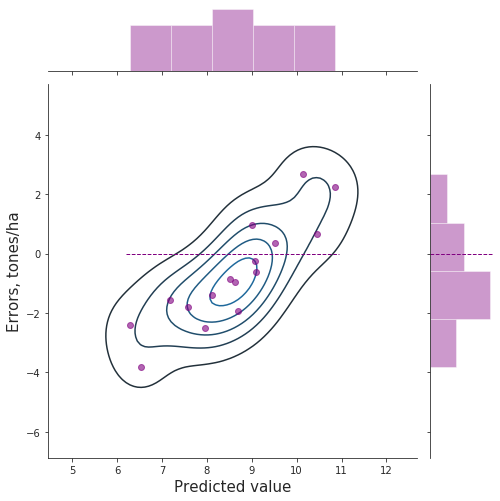

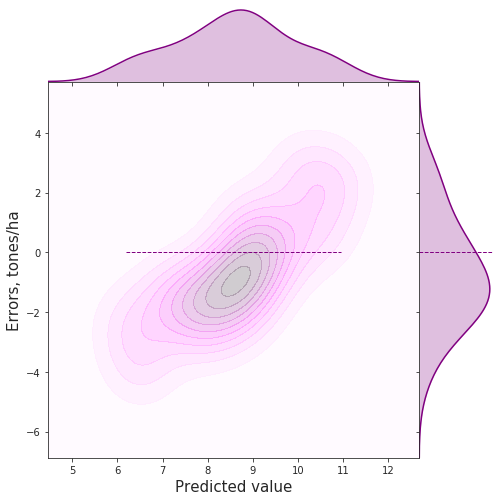

In [20]:
print_metrics(y_test, predicted_Italy, LR, r2 = True)
residuals_plots(y_test, predicted_Italy, color = 'purple')

## Spain

In [21]:
data_spain = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/Spain.csv', sep = ',')
data_spain.dropna(axis=1, inplace=True)
data_spain.drop('Entity', inplace=True, axis=1)
data_spain.drop('Greece_pressure', inplace=True, axis=1)
data_spain.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      202.69518         33.0     1016.92914       1009.20120   
1      313.65823         42.0     1015.79340       1009.78467   
2      366.94125         55.0     1012.74615       1016.32874   
3      272.83627         39.0     1015.32947       1015.11957   
4      212.56216         34.0     1016.05140       1011.64570   
5      352.97882         49.0     1014.90800       1014.03540   
6      242.02579         37.0     1016.85840       1009.69420   
7      288.80646         44.0     1014.57260       1009.11145   
8      430.24475         57.0     1012.22400       1015.93990   
9      309.74210         44.0     1014.50150       1012.04740   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0        1013.95790         1019.94550        32.441740        -3.615373   
1        1016.03094         1018.48090        32.277878        -4.011756   
2        1012.46265         1015.33850        32.872925        -7.577134   
3        1015.07240         1017.66310        33.298970        -5.288595   
4        1014.87500         1018.06440        35.454190        -6.712173   
5        1009.56040         1017.36520        32.153380        -2.088718   
6        1014.27050         1019.34357        31.831453        -5.154420   
7        1014.11380         1017.58850        35.739860        -5.065962   
8        1011.61285         1015.11566        32.013317        -5.613965   
9        1012.38770         1017.49230        31.479155        -4.705809   

   Temperature_SAT  Year  ...  Maize (tonnes per hectare)  \
0        1810.8169  1961  ...                      2.3882   
1        1466.5785  1962  ...                      2.1408   
2        1426.8755  1963  ...                      2.4044   
3        1640.2798  1964  ...                      2.3392   
4        1620.6001  1965  ...                      2.3876   
5        1600.9751  1966  ...                      2.3938   
6        1413.7897  1967  ...                      2.5010   
7        1407.3450  1968  ...                      2.8168   
8        1350.0808  1969  ...                      3.0487   
9        1398.0907  1970  ...                      3.4278   

   Potatoes (tonnes per hectare)  Beans (tonnes per hectare)  \
0                        11.8126                      0.6341   
1                        10.1604                      0.5004   
2                        12.3557                      0.5493   
3                        11.6488                      0.5247   
4                        11.0710                      0.5265   
5                        11.8083                      0.5490   
6                        11.9349                      0.5373   
7                        11.8969                      0.5348   
8                        12.7156                      0.5601   
9                        13.3553                      0.6036   

   Peas (tonnes per hectare)  Barley (tonnes per hectare)  \
0                     0.7633                       1.2026   
1                     0.8009                       1.4916   
2                     0.8285                       1.4309   
3                     0.7359                       1.3953   
4                     0.5994                       1.3762   
5                     0.7868                       1.4997   
6                     0.8380                       1.7174   
7                     0.8008                       1.7894   
8                     0.8780                       1.8376   
9                     0.7444                       1.3953   

   Bananas (tonnes per hectare)  Total population (Gapminder)  \
0                       33.1895                    30730000.0   
1                       31.8125                    31075000.0   
2                       35.5104                    31433000.0   
3                       37.1633                    31792000.0   
4                       37.6162                    32146000.0   
5          

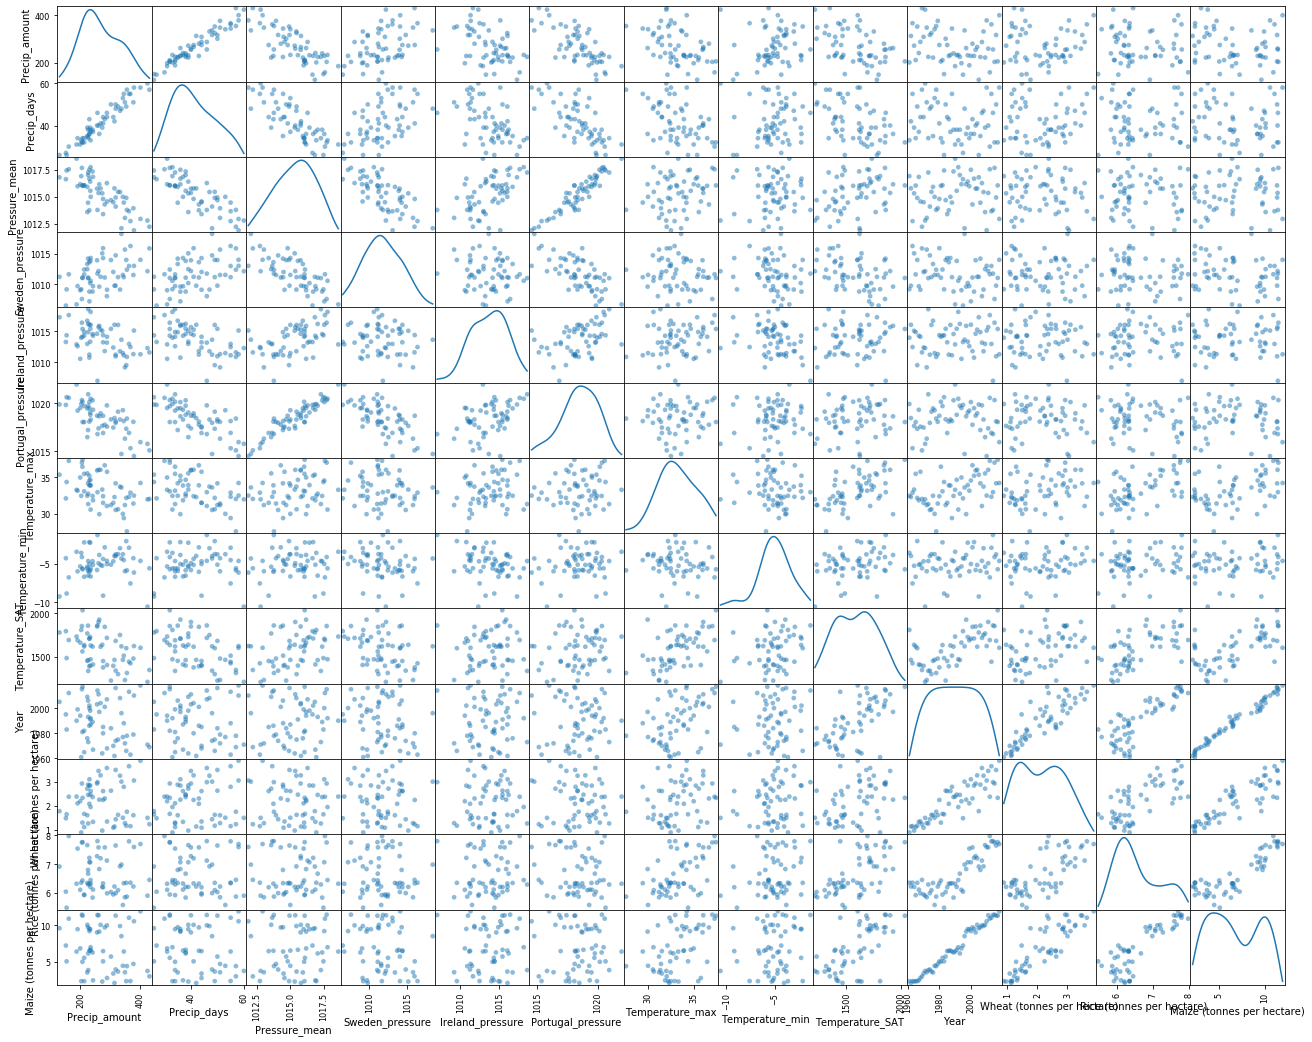

In [22]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_spain.loc[:, "Precip_amount":"Maize (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

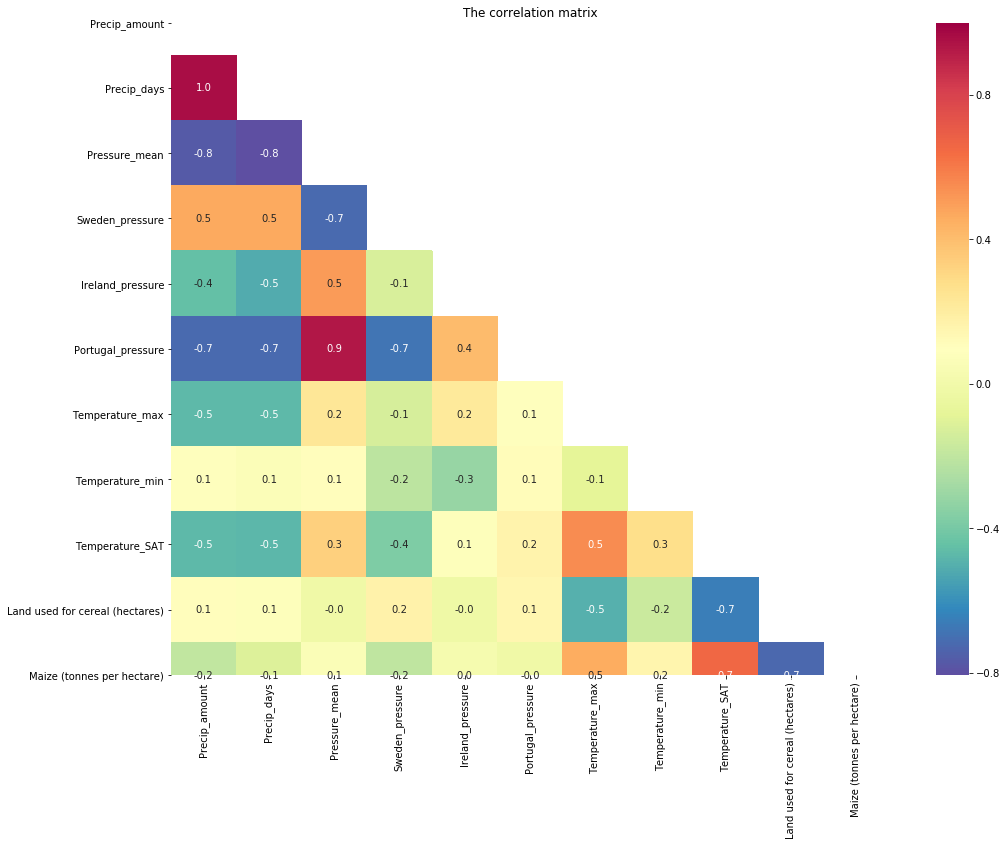

In [23]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_spain[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Maize (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.

In [24]:
cum_sum(data_spain['Maize (tonnes per hectare)'], data_spain['Year'])

No fractures were found


### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min
* Year

In [25]:
data_spain['year'] = data_spain['Year']
data_spain.set_index('year', inplace=True)
data_train = data_spain.loc[1961:2003]
data_test = data_spain.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min', 'Year']])
                          
y_train = data_train['Maize (tonnes per hectare)']
y_test = data_test['Maize (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Spain = LR.predict(X_test)

Mean absolute error in the test sample - 0.4568653810884956
Median absolute error in the test sample - 0.5701901033511394
Root mean square error in the test sample - 0.5414073679100828
Mean absolute percentage error in the test sample - 4.345524006522737
Coefficient of determination in the training sample - 0.9690890736295674


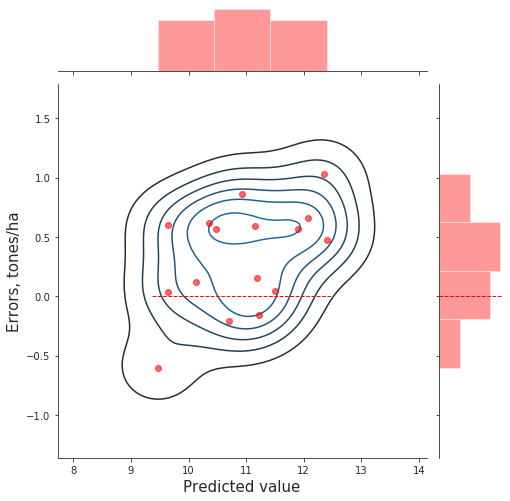

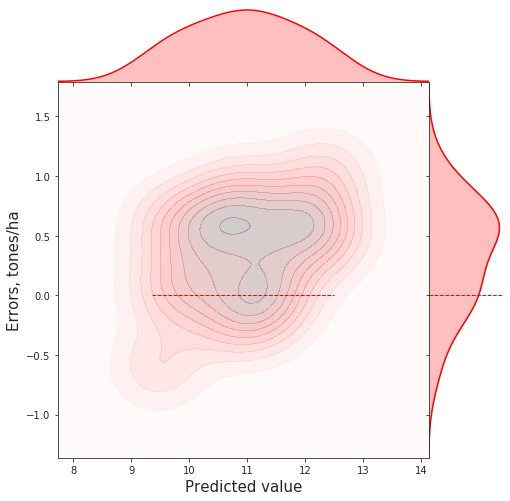

In [26]:
print_metrics(y_test, predicted_Spain, LR, r2 = True)
residuals_plots(y_test, predicted_Spain, color = 'red')

## Czech Republic

In [27]:
data_cz = pd.read_csv('/media/mikhail/Data/ITMO/Reanalysis_grid_Europe/Processed_grid/Czech Republic.csv', sep = ',')
data_cz.dropna(axis=1, inplace=True)
data_cz.drop('Entity', inplace=True, axis=1)
data_cz.drop('Greece_pressure', inplace=True, axis=1)
data_cz.head(10)

Precip_amount  Precip_days  Pressure_mean  Sweden_pressure  \
0      236.90952         57.0     1019.72130       1011.10520   
1      261.69336         63.0     1015.48680       1009.03830   
2      365.54355         78.0     1015.23890       1006.50680   
3      291.06827         54.0     1017.60360       1018.32810   
4      251.62720         58.0     1019.54540       1009.63100   
5      233.82738         52.0     1017.39514       1010.21090   
6      286.72226         67.0     1015.69130       1009.71810   
7      305.16748         69.0     1017.80220       1007.20264   
8      300.80610         68.0     1015.02390       1011.13770   
9      276.06805         54.0     1017.70856       1008.80410   

   Ireland_pressure  Portugal_pressure  Temperature_max  Temperature_min  \
0        1016.17365         1019.76685        29.180721       -18.573154   
1        1010.57825         1019.53260        33.725000       -15.198441   
2        1013.27460         1019.85250        28.035152       -12.810456   
3        1013.64050         1014.73600        30.914106       -18.143785   
4        1015.85864         1018.66364        31.069088       -16.072071   
5        1013.32650         1019.06020        33.071995       -19.110321   
6        1012.59894         1019.25440        29.083517       -16.285055   
7        1016.04470         1020.14880        34.305950       -16.201557   
8        1011.81440         1017.78550        28.685057       -14.457433   
9        1010.76850         1019.51056        32.528786       -19.198270   

   Temperature_SAT  Year  Wheat (tonnes per hectare)  \
0       1113.89430  1993                      4.2350   
1        989.57990  1994                      4.5800   
2        882.71570  1995                      4.6016   
3        988.33460  1996                      4.6671   
4        879.50323  1997                      4.4100   
5       1082.73240  1998                      4.2143   
6       1027.12410  1999                      4.6457   
7       1219.02400  2000                      4.2085   
8        927.59020  2001                      4.8483   
9       1128.99770  2002                      4.5551   

   Maize (tonnes per hectare)  Soybeans (tonnes per hectare)  \
0                      4.8746                         1.1180   
1                      3.3896                         1.0217   
2                      4.2840                         1.2912   
3                      5.0927                         1.4234   
4                      6.9250                         1.3655   
5                      6.0948                         1.2529   
6                      6.6037                         1.6027   
7                      6.4285                         1.2463   
8                      6.5978                         1.5894   
9                      8.7322                         2.1289   

   Potatoes (tonnes per hectare)  Peas (tonnes per hectare)  \
0                        23.3019                     2.4462   
1                        16.0557                     2.4219   
2                        17.0815                     2.5006   
3                        21.0042                     2.5452   
4                        19.3000                     2.1247   
5                        21.1505                     2.3890   
6                        19.6884                     2.6531   
7                        21.3300                     2.2248   
8                        20.8818                     2.5685   
9                        23.5121                     2.0073   

   Barley (tonnes per hectare)  Total population (Gapminder)  \
0                       3.7999                    10359000.0   
1                       3.7780                    10361000.0   
2                       3.8386                    10358000.0   
3                       3.7716                    10350000.0   
4                       3.8431                    10338000.0   
5                       3.6232                    

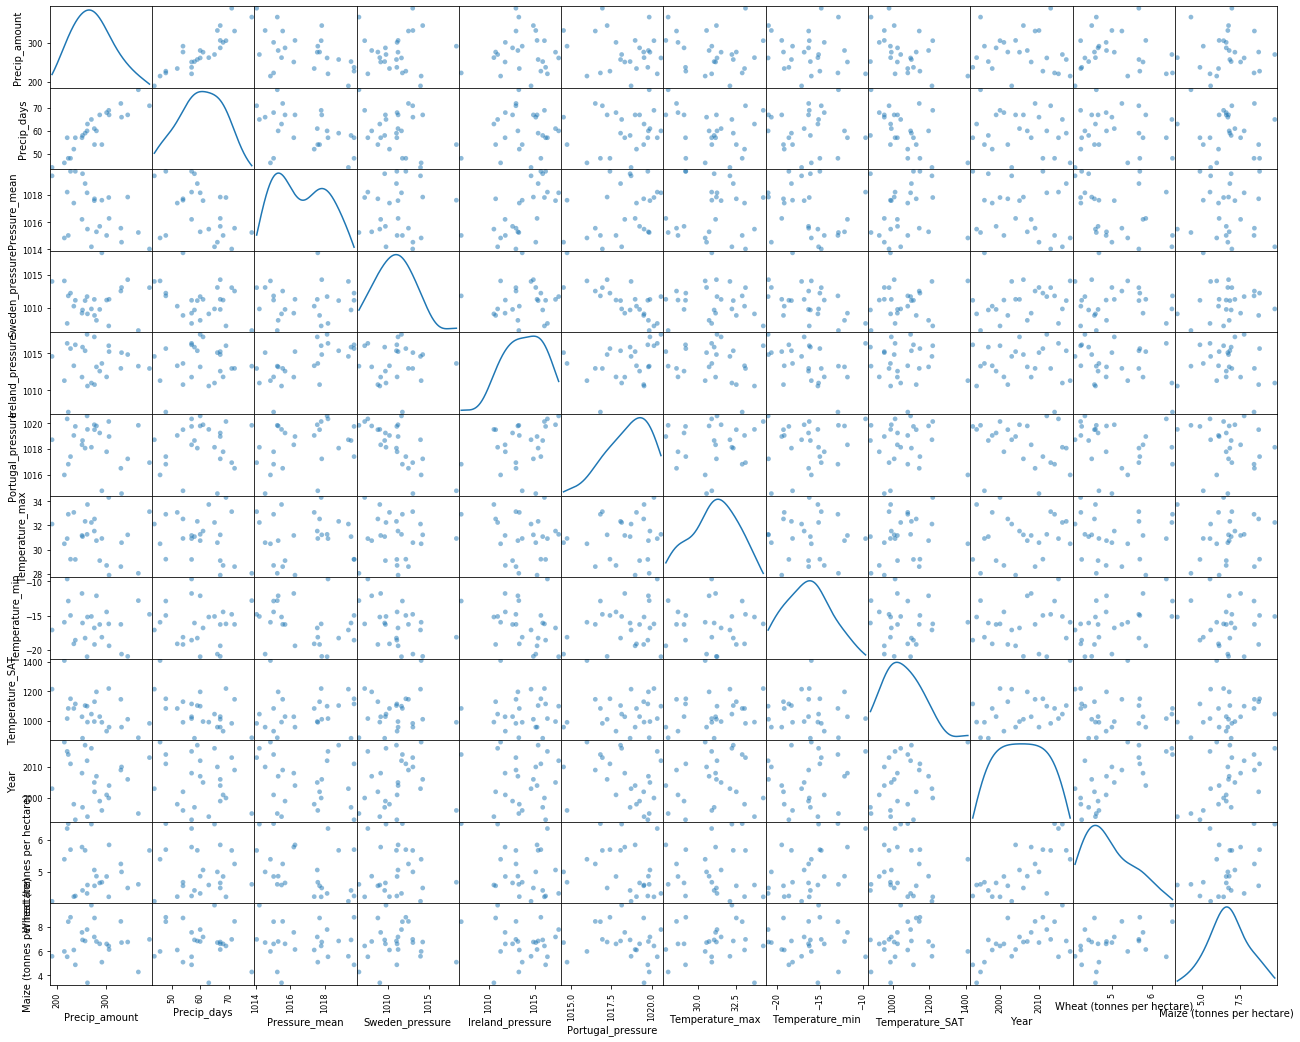

In [28]:
rcParams['figure.figsize'] = 22, 18

pd.plotting.scatter_matrix(data_cz.loc[:, "Precip_amount":"Maize (tonnes per hectare)"], 
                           diagonal="kde", s = 90)
plt.show()

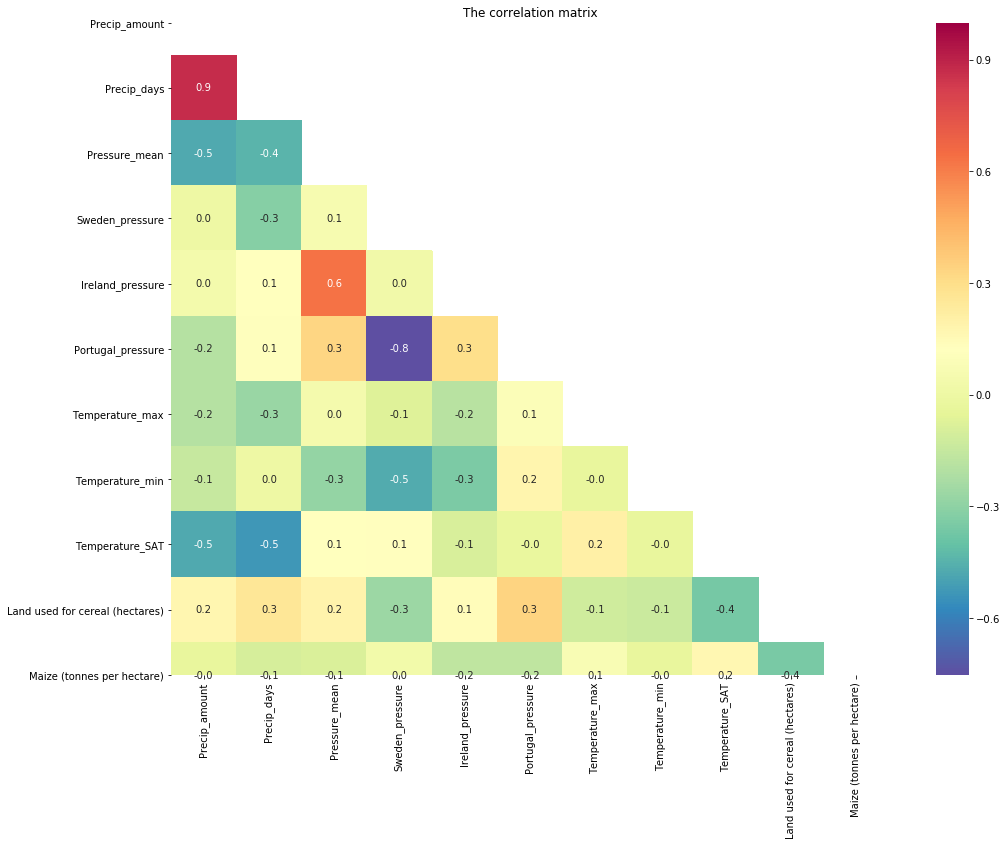

In [29]:
rcParams['figure.figsize'] = 17, 12

Newtable = data_cz[['Precip_amount', 'Precip_days', 'Pressure_mean', 'Sweden_pressure',
                'Ireland_pressure', 'Portugal_pressure', 'Temperature_max', 'Temperature_min',
                'Temperature_SAT','Land used for cereal (hectares)', 'Maize (tonnes per hectare)']]
Newtable = Newtable.dropna()

corrs = Newtable.corr()
mask = np.zeros_like(corrs)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corrs, cmap='Spectral_r', annot=True, fmt= '.1f', mask = mask, square = True)
plt.title('The correlation matrix')
plt.show()

### Checking samples for homogeneity

##### Cumulative sum method and statistical testing to divide the sample into homogeneous parts

The method of integral curves or accumulated (cumulative) sum was initially used in hydrology to check whether or not there are directional changes (trends) in the interannual dynamics of annual river flows. Subsequently, it was used for preliminary analysis of interannual variability of any environmental parameters.

The method is as follows. Graph: x-axis numbers refer to years, y-axis – the accumulated amount of average or total for the year parameter values. The accumulated amount for a given year is the sum of the values of the series from its very beginning to this year. For the first year of the series, this is the value itself, for the second year-the sum of the values of the first and second years, and so on. The points of accumulated sum on the chart are connected by a line. If there is no pronounced inter-annual trend in changing the values of the series, the curve is close to a straight line. If there are breaks on the curve, this may indicate that the sample is not uniform.

In [30]:
cum_sum(data_cz['Maize (tonnes per hectare)'], data_cz['Year'])

No fractures were found


### Multiple linear regression

Predictors:
* Precip_amount
* Temperature_SAT
* Precip_days
* Pressure_mean
* Temperature_min

In [31]:
data_cz['year'] = data_cz['Year']
data_cz.set_index('year', inplace=True)
data_train = data_cz.loc[1993:2003]
data_test = data_cz.loc[2003:2018]

# Предикторы
scaler = StandardScaler()
X_train = scaler.fit_transform(data_train[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
X_test = scaler.transform(data_test[['Precip_amount' , 'Temperature_SAT', 'Precip_days', 'Pressure_mean', 'Temperature_min']])
                          
y_train = data_train['Maize (tonnes per hectare)']
y_test = data_test['Maize (tonnes per hectare)']
                          
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

# Обучение линейной регрессии
LR = LinearRegression()
LR.fit(X_train, y_train)
predicted_Cz = LR.predict(X_test)

Mean absolute error in the test sample - 1.9461004196662564
Median absolute error in the test sample - 1.3280769618307624
Root mean square error in the test sample - 2.4489798602468134
Mean absolute percentage error in the test sample - 25.643565088855368
Coefficient of determination in the training sample - 0.21223787638145275


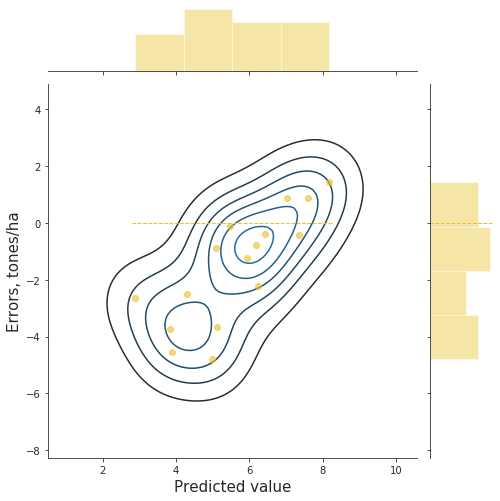

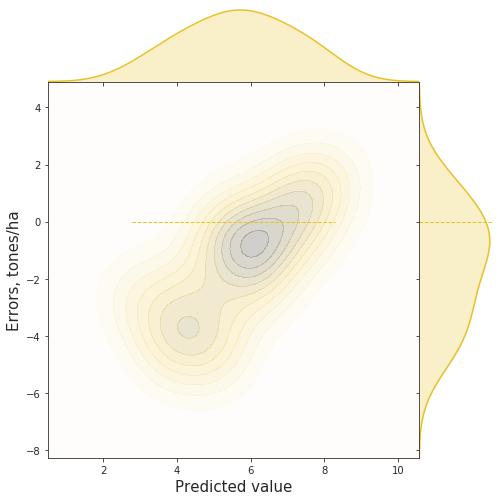

In [32]:
print_metrics(y_test, predicted_Cz, LR, r2 = True)
residuals_plots(y_test, predicted_Cz, color = '#E8C125')

## Comparing yields in different countries

In [33]:
data = pd.DataFrame({'Germany_Maize': data_germany['Maize (tonnes per hectare)'],
                     'France_Maize': data_france['Maize (tonnes per hectare)'],
                     'Italy_Maize': data_italy['Maize (tonnes per hectare)'],
                     'Spain_Maize': np.array(data_spain['Maize (tonnes per hectare)']),
                     'Cz_Maize': data_cz['Maize (tonnes per hectare)'],
                     'Germany_SAT': data_germany['Temperature_SAT'],
                     'France_SAT': data_france['Temperature_SAT'],
                     'Italy_SAT': data_italy['Temperature_SAT'],
                     'Spain_SAT': np.array(data_spain['Temperature_SAT']),
                     'Cz_SAT': data_cz['Temperature_SAT']})
data.reset_index()
data.dropna(inplace=True)
data.head(10)

Germany_Maize  France_Maize  Italy_Maize  Spain_Maize  Cz_Maize  \
year                                                                    
1993         8.0227        8.0479       8.6612       6.1736    4.8746   
1994         7.0808        7.7983       8.2235       6.8566    3.3896   
1995         7.3664        7.7182       8.9695       7.2459    4.2840   
1996         7.8272        8.3856       9.3328       8.5308    5.0927   
1997         8.6577        9.0651       9.6270       9.1501    6.9250   
1998         8.1561        8.4528       9.3217       9.4731    6.0948   
1999         8.7850        8.9523       9.7444       9.4808    6.6037   
2000         9.2119        9.0766       9.5277       9.2157    6.4285   
2001         8.8376        8.5711       9.5135       9.7208    6.5978   
2002         9.3755        8.9751       9.4918       9.5142    8.7322   

      Germany_SAT  France_SAT  Italy_SAT  Spain_SAT      Cz_SAT  
year                                                             
1993   1139.90190   1313.4785  1546.2046  1464.0131  1113.89430  
1994    994.95654   1255.4575  1675.8830  1665.2158   989.57990  
1995    832.75336   1143.9457  1451.7655  1796.6329   882.71570  
1996    883.55320   1150.4257  1551.6321  1622.3251   988.33460  
1997    882.92530   1330.8687  1613.0465  1929.2893   879.50323  
1998   1107.96960   1294.8234  1668.9205  1729.4426  1082.73240  
1999   1050.54140   1342.2523  1649.5712  1691.8840  1027.12410  
2000   1158.27980   1306.8102  1711.2867  1709.6874  1219.02400  
2001    938.76953   1334.1871  1854.3220  1846.1985   927.59020  
2002   1092.53630   1377.6257  1812.9551  1713.0180  1128.99770

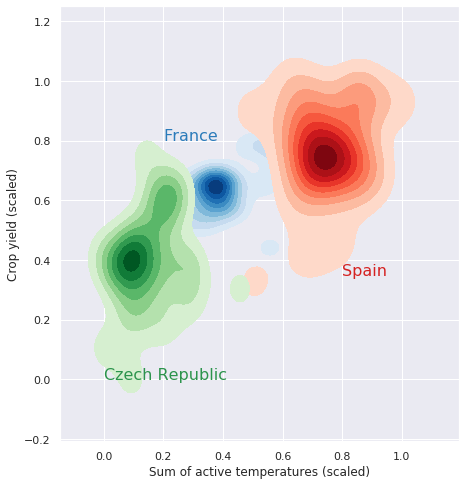

In [34]:
from sklearn.preprocessing import MinMaxScaler

SAT = np.vstack((np.array(data['France_SAT']), 
                 np.array(data['Spain_SAT']), 
                 np.array(data['Cz_SAT'])))
SAT = np.ravel(SAT)

Maize = np.vstack((np.array(data['France_Maize']), 
                   np.array(data['Spain_Maize']), 
                   np.array(data['Cz_Maize'])))
Maize = np.ravel(Maize)

zer = np.full(len(data['France_SAT']), 'France')
ones = np.full(len(data['Spain_SAT']), 'Spain')
tres = np.full(len(data['Cz_SAT']), 'Czech')
code = np.vstack((zer, ones, tres))
code = np.ravel(code)

new_data = pd.DataFrame({'SAT': SAT, 
                         'Maize': Maize,
                         'Code': code})
new_data['Sum of active temperatures (scaled)'] = new_data['SAT']
new_data['Crop yield (scaled)'] = new_data['Maize']
scaler = MinMaxScaler()
new_data[['Sum of active temperatures (scaled)', 'Crop yield (scaled)']] = scaler.fit_transform(new_data[['SAT', 'Maize']])


sns.set(style="darkgrid")

# Subset the iris dataset by species
france = new_data.query("Code == 'France'")
spain = new_data.query("Code == 'Spain'")
czech = new_data.query("Code == 'Czech'")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(france['Sum of active temperatures (scaled)'], france['Crop yield (scaled)'],
                 cmap="Blues", shade=True, shade_lowest=False)
ax = sns.kdeplot(spain['Sum of active temperatures (scaled)'], spain['Crop yield (scaled)'],
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(czech['Sum of active temperatures (scaled)'], czech['Crop yield (scaled)'],
                 cmap="Greens", shade=True, shade_lowest=False)

blue = sns.color_palette("Blues")[-2]
red = sns.color_palette("Reds")[-2]
green = sns.color_palette("Greens")[-2]
ax.text(0.2, 0.8, "France", size=16, color=blue)
ax.text(0.8, 0.35, "Spain", size=16, color=red)
ax.text(0.0, 0.0, "Czech Republic", size=16, color=green)
plt.show()

Thus, it is clear that the dependencies for countries are not trivial, which is why we built models separately for each country.